In [1]:
processed_data_dir = '../data/processed'
engineered_data_dir = '../data/engineered'
model_dir = '../models'

In [2]:
import os
import pandas as pd

X_train_scaled = pd.read_csv(os.path.join(processed_data_dir, 'X_train_scaled.csv'))
X_val_scaled = pd.read_csv(os.path.join(processed_data_dir, 'X_val_scaled.csv'))
X_test_scaled = pd.read_csv(os.path.join(processed_data_dir, 'X_test_scaled.csv'))

y_train = pd.read_csv(os.path.join(processed_data_dir, 'y_train.csv'))
y_val = pd.read_csv(os.path.join(processed_data_dir, 'y_val.csv'))

In [3]:
import torch

train_tensor = torch.FloatTensor(X_train_scaled.values)
val_tensor = torch.FloatTensor(X_val_scaled.values)
test_tensor = torch.FloatTensor(X_test_scaled.values)

In [4]:
non_fraud_mask_train = (y_train == 0).values
non_fraud_mask_val = (y_val == 0).values

In [5]:
X_train_non_fraud = X_train_scaled[non_fraud_mask_train]
X_val_non_fraud = X_val_scaled[non_fraud_mask_val]

In [6]:
from torch.utils.data import TensorDataset

In [7]:
train_dataset = TensorDataset(torch.tensor(X_train_non_fraud.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val_non_fraud.values, dtype=torch.float32))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        
        # Encoder layers
        self.enc1 = nn.Linear(input_dim, 128)
        self.enc_act1 = nn.ReLU()
        self.enc2 = nn.Linear(128, 64)
        self.enc_bn = nn.BatchNorm1d(64)
        self.enc_act2 = nn.ReLU()
        self.enc3 = nn.Linear(64, encoding_dim)
        self.dropout = nn.Dropout(0.2)
        
        # Decoder layers
        self.dec1 = nn.Linear(encoding_dim, 64)
        self.dec_act1 = nn.ReLU()
        self.dec2 = nn.Linear(64, 128)
        self.dec_act2 = nn.ReLU()
        self.dec3 = nn.Linear(128, input_dim)

    def forward(self, x):
        # Encoder
        enc1_out = self.enc_act1(self.enc1(x))
        enc2_out = self.enc_act2(self.enc_bn(self.enc2(enc1_out)))
        encoding = self.enc3(enc2_out)
        drop = self.dropout(encoding)
        
        # Decoder with skip connections
        dec1_out = self.dec_act1(self.dec1(drop))
        # Skip connection from enc2_out to decoder
        dec2_in = dec1_out + enc2_out
        dec2_out = self.dec_act2(self.dec2(dec2_in))
        # Skip connection from enc1_out to decoder
        dec3_in = dec2_out + enc1_out
        output = self.dec3(dec3_in)
        
        return output

# Initialize
input_dim = X_train_scaled.shape[1]
encoding_dim = 32
autoencoder = Autoencoder(input_dim, encoding_dim).to(device)

In [10]:
class Encoder(nn.Module):
    def __init__(self, autoencoder):
        super(Encoder, self).__init__()
        
        # Copy the encoder layers from the autoencoder
        self.enc1 = autoencoder.enc1
        self.enc_act1 = autoencoder.enc_act1
        self.enc2 = autoencoder.enc2
        self.enc_bn = autoencoder.enc_bn
        self.enc_act2 = autoencoder.enc_act2
        self.enc3 = autoencoder.enc3

    def forward(self, x):
        # Forward pass through the encoder
        x = self.enc_act1(self.enc1(x))
        x = self.enc_act2(self.enc_bn(self.enc2(x)))
        x = self.enc3(x)
        
        return x

In [11]:
lr = 1e-4
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

epochs = 100
train_losses = []
val_losses = []
best_loss = float('inf')
save_path = os.path.join(model_dir, 'best_autoencoder.pth')

In [12]:
from torch.utils.data import DataLoader

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count())

In [13]:
from tqdm.notebook import tqdm

epoch_bar = tqdm(range(epochs), desc='Training Autoencoder', unit='epoch')
for epoch in epoch_bar:
    # Training phase
    autoencoder.train()
    epoch_train_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False, unit='batch'):
        batch = batch[0].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), 1.0)
        optimizer.step()
        epoch_train_loss += loss.item() * batch.size(0)
    
    # Validation phase
    autoencoder.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch[0].to(device)
            outputs = autoencoder(batch)
            loss = criterion(outputs, batch)
            epoch_val_loss += loss.item() * batch.size(0)
    
    # Calculate metrics
    train_loss = epoch_train_loss / len(train_loader.dataset)
    val_loss = epoch_val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Update progress bar
    epoch_bar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Val Loss': f'{val_loss:.4f}',
        'LR': f'{optimizer.param_groups[0]['lr']:.2e}'
    })
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(autoencoder.state_dict(), save_path)
    
    # Learning rate scheduling
    scheduler.step(val_loss)

Training Autoencoder:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 2:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 4:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 5:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 6:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 7:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 8:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 9:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 10:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 11:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 12:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 13:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 14:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 15:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 16:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 17:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 18:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 19:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 20:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 21:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 22:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 23:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 24:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 25:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 26:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 27:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 28:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 29:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 30:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 31:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 32:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 33:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 34:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 35:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 36:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 37:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 38:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 39:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 40:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 41:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 42:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 43:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 44:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 45:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 46:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 47:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 48:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 49:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 50:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 51:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 52:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 53:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 54:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 55:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 56:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 57:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 58:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 59:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 60:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 61:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 62:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 63:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 64:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 65:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 66:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 67:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 68:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 69:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 70:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 71:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 72:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 73:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 74:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 75:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 76:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 77:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 78:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 79:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 80:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 81:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 82:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 83:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 84:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 85:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 86:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 87:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 88:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 89:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 90:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 91:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 92:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 93:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 94:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 95:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 96:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 97:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 98:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 99:   0%|          | 0/756 [00:00<?, ?batch/s]

Epoch 100:   0%|          | 0/756 [00:00<?, ?batch/s]

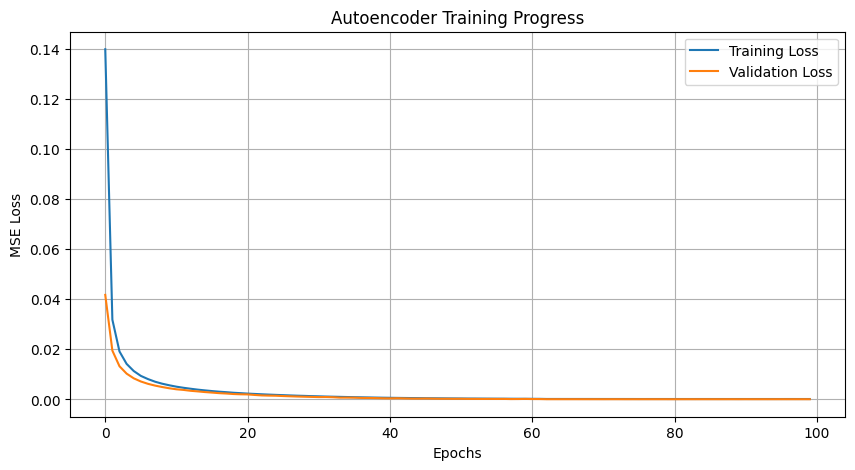

In [14]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Autoencoder Training Progress')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
autoencoder.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [16]:
autoencoder.eval()
encoder = Encoder(autoencoder).eval()

In [17]:
# Generate encoded features
with torch.no_grad():
    encoded_train = encoder(train_tensor.to(device)).cpu().numpy()
    encoded_val = encoder(val_tensor.to(device)).cpu().numpy()
    encoded_test = encoder(test_tensor.to(device)).cpu().numpy()

In [18]:
# Save encoded features
pd.DataFrame(encoded_train).to_csv(os.path.join(engineered_data_dir, 'encoded_features_train.csv'), index=False)
pd.DataFrame(encoded_val).to_csv(os.path.join(engineered_data_dir, 'encoded_features_val.csv'), index=False)
pd.DataFrame(encoded_test).to_csv(os.path.join(engineered_data_dir, 'encoded_features_test.csv'), index=False)

In [19]:
original_features_train = pd.read_csv(os.path.join(processed_data_dir, 'X_train_scaled.csv'))
encoded_features_train = pd.read_csv(os.path.join(engineered_data_dir, 'encoded_features_train.csv'))
enriched_data_train = pd.concat([original_features_train, encoded_features_train], axis=1)

original_features_val = pd.read_csv(os.path.join(processed_data_dir, 'X_val_scaled.csv'))
encoded_features_val = pd.read_csv(os.path.join(engineered_data_dir, 'encoded_features_val.csv'))
enriched_data_val = pd.concat([original_features_val, encoded_features_val], axis=1)

original_features_test = pd.read_csv(os.path.join(processed_data_dir, 'X_test_scaled.csv'))
encoded_features_test = pd.read_csv(os.path.join(engineered_data_dir, 'encoded_features_test.csv'))
enriched_data_test = pd.concat([original_features_test, encoded_features_test], axis=1)

In [20]:
pd.DataFrame(enriched_data_train).to_csv(os.path.join(engineered_data_dir, 'X_train_enriched.csv'), index=False)
pd.DataFrame(enriched_data_val).to_csv(os.path.join(engineered_data_dir, 'X_val_enriched.csv'), index=False)
pd.DataFrame(enriched_data_test).to_csv(os.path.join(engineered_data_dir, 'X_test_enriched.csv'), index=False)